**mask reconstruction for a s2 product downloaded on google drive: S2A_MSIL1C_20190623T101031_N0500_R022_T32TQR_20230619T042008.SAFE**

In [1]:
import os
import sys
import pandas as pd
import requests
import json
import datetime
from tqdm import tqdm
# from dotenv import load_dotenv

# 1 Required satellite category
query_satellite = 'SENTINEL-2'

# 2 String to be included in filename for retrieval of specific product by name, 
# i.e L1C, and code for tile name
query_product = 'S2A_MSIL1C_'
query_tile = 'T33TUL'   # best tile for Po River Delta = 'T33TUL' -- other Po delta tiles (overlap) T33TUK, T32TQQ, T32TQR,
# other AOIs: CALABRIA: 'T33SXC' | NE CORSICA  = 'T32TNN'

# 3 Enter a start and end date
query_startDate = '2019-07-20'
query_endDate = '2019-07-31'

# 4 Load geo.json polygon of area of interest: 
# map_geojson = './map.geojson'

# 6 load your credentials from .env
# load_dotenv()
# username=os.getenv("CDSE_email")
# password=os.getenv("CDSE_password")
username = "dhia12naouali@gmail.com"
password = "Dhia12naouali@gmail.com"
# if not already in .env config, insert them as 'string' 
# values in the following format to the .env file:
CDSE_email = username
CDSE_password = password

# 7 Set output file:
output_dir = '../data/SAFE/March2019' #edit as appropriate to add batch folders

def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username":username,
        "password":password,
        "grant_type": "password",
        }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
            )
    print("Access token created successfully!")
    return r.json()["access_token"]

def get_https_request(satellite, product, tile, start_date, end_date): #, geojson
    
    base_prefix = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="
    collection = "Collection/Name eq '" + satellite + "' and startswith(Name,'" + product + "') and contains(Name,'" + tile + "')"
    #roi_coordinates = get_coordinates(geojson)
    #geographic_criteria = "OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((" + roi_coordinates + "))') "
    content_date = (
            "ContentDate/Start gt " + start_date + "T00:00:00.000Z and " +
            "ContentDate/Start lt " + end_date + "T00:00:00.000Z"
    )
    https_request = ( base_prefix + collection +  " and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le 20.00) and " 
                     + content_date) # geographic_criteria + " and " +
    print("Query URL:", https_request)
    return https_request


def download_data(token, id, name, length, output):
    url = f"https://download.dataspace.copernicus.eu/odata/v1/Products({id})/$value"
    headers = {"Authorization": f"Bearer {token}"}
    session = requests.Session()
    session.headers.update(headers)
    response = session.get(url, headers=headers, stream=True)
    try:
        print('[', datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S'), '] '+'Downloading: '+name)
        with open(output, "wb") as file:
            if length is not None:
                # set the total length of the progress bar for tracking downloads
                pbar = tqdm(total=length, unit="B", unit_scale=True, desc=name)
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        file.write(chunk)
                        # update progress bar
                        pbar.update(len(chunk))
                pbar.close()
        print('[', datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S'), '] '+'Download complete: '+name)
        response.close()
    except Exception as e:
        print('[', datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S'), '] '+'Download failed: '+name)
        print(f"An exception occured: {e}")

# zip the Safe files for download
def get_file_name(name):
    file_name = ''
    if query_satellite == 'SENTINEL-1':
        file_name = name.replace(".SAFE", ".zip")
    elif query_satellite == 'SENTINEL-2':
        file_name = name.replace(".SAFE", ".zip")
    elif query_satellite == 'SENTINEL-3':
        file_name = name.replace(".SEN3", ".zip")
    elif query_satellite == 'SENTINEL-5P':
        file_name = name.replace(".nc", ".zip")
    elif query_satellite == 'SENTINEL-6':
        file_name = name.replace(".SEN6", ".zip")
    return file_name

request_url = get_https_request(
    query_satellite, query_product, query_tile, query_startDate, query_endDate #, map_geojson, 
)
JSON = requests.get(request_url).json()
if 'detail' in JSON:
    print(JSON['detail']['message'])
    sys.exit()
elif 'value' in JSON:
    df = pd.DataFrame.from_dict(JSON['value'])
    # print(df.columns)
    if len(df) == 0:
        print('No data found')
        sys.exit()
    
    data_id_list = df.Id
    data_name_list = df.Name
    date_content_length = df.ContentLength
else:
    print('Unknown query error')
    sys.exit()

for i in range(len(data_id_list)):
    print(data_name_list[i])
    data_id = data_id_list[i]
    data_name = get_file_name(data_name_list[i])
    data_length = date_content_length[i]
    # Check if the data storage path exists. If not, create the data storage path.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_file = os.path.join(output_dir, data_name)
    # # Check if the file has been downloaded before of it has no recorded windrows, in either case, skip it and do not download it (again).
    litterrows = pd.read_excel('/kaggle/input/LW_centroids.xlsx')
    samples_set = set(litterrows['Str_time'])
    if os.path.exists(output_file) and os.path.getsize(output_file) == data_length:
        print(output_file + 'File already exists')   
    elif output_file[34:49] not in samples_set:
        print(output_file + ' has no recorded litter rows' )
    else:
        access_token = get_access_token(CDSE_email, CDSE_password)
        download_data(access_token, data_id, data_name, data_length, output_file)

Query URL: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and startswith(Name,'S2A_MSIL1C_') and contains(Name,'T33TUL') and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le 20.00) and ContentDate/Start gt 2019-07-20T00:00:00.000Z and ContentDate/Start lt 2019-07-31T00:00:00.000Z
S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.SAFE
Access token created successfully!
[ 17:07:52 ] Downloading: S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.zip


S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.zip: 100%|██████████| 637M/637M [01:34<00:00, 6.73MB/s] 


[ 17:09:27 ] Download complete: S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.zip
S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.SAFE
Access token created successfully!
[ 17:09:31 ] Downloading: S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.zip


S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.zip: 100%|██████████| 693M/693M [00:35<00:00, 19.8MB/s] 


[ 17:10:06 ] Download complete: S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.zip
S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.SAFE
Access token created successfully!
[ 17:10:10 ] Downloading: S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.zip


S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.zip: 100%|██████████| 698M/698M [03:04<00:00, 3.79MB/s] 

[ 17:13:14 ] Download complete: S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.zip


In [2]:
!pip -q install sentinelhub cartopy
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

from PIL import Image
import numpy as np
import os

import geopandas as gpd
from shapely.geometry import box

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import cartopy
# from utils import plot_image

# Only run this cell if you have not created a configuration.

config = SHConfig()

# config.sh_client_id = "sh-84d21c38-65f5-410d-9267-b1db4ba47b41"
# config.sh_client_secret = "7ykprUj53bYD42W30gevmHFnI4U5y75M"


config.sh_client_id = "sh-19687381-5319-4ca5-8925-3f03e13acaa7"
config.sh_client_secret = "hJBDJ0H4FAWs57X3Yi2u1YE2ywL4t5oU"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

catalog = SentinelHubCatalog(config=config)
resolution = 10

def download_sentinel_images(aoi_coords_wgs84, time_interval, output_dir="Images", resolution=10, max_size=2500):
    """
    Downloads Sentinel-2 true color images for a given AOI and time range.

    Parameters:
    - aoi_coords_wgs84: list of [min_lon, min_lat, max_lon, max_lat] (AOI bounding box)
    - time_interval: tuple of (start_date, end_date) in 'YYYY-MM-DD' format
    - output_dir: Directory to save the images (default: 'Po_Images')
    - resolution: Spatial resolution in meters per pixel (default: 10m)
    - max_size: Maximum image size (Sentinel Hub limit: 2500 pixels)
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define AOI Bounding Box
    aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
    aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
    aoi_size = (min(aoi_size[0], max_size), min(aoi_size[1], max_size))  # Limit size

    # Search for available Sentinel-2 images
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )

    results = list(search_iterator)
    print(f"Total number of results: {len(results)}")

    if not results:
        print("No images found for the given AOI and time interval.")
        return []

    # Define SentinelHub evalscript for true color imagery
    evalscript_true_color = """
        //VERSION=3
        function setup() {
            return { input: [{ bands: ["B02", "B03", "B04"] }], output: { bands: 3 } };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """

    true_color_imgs = []

    # Loop through results to fetch corresponding images
    for result in results:
        timestamp = result["properties"]["datetime"]
        print(f"Fetching image for timestamp: {timestamp}")

        # Request the image
        request_true_color = SentinelHubRequest(
            evalscript=evalscript_true_color,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A.define_from(
                        name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                    ),
                    time_interval=(timestamp, timestamp),
                    other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=aoi_bbox,
            size=aoi_size,
            config=config,
        )

        # Get the image
        image_data = request_true_color.get_data()

        if image_data:
            image = image_data[0]  # Extract the first image
            true_color_imgs.append(image)

            # Save the image
            formatted_timestamp = timestamp[:19].replace(":", "-")
            filename = os.path.join(output_dir, f"sentinel_image_{formatted_timestamp}.png")
            img = Image.fromarray(np.uint8(image))
            img.save(filename)

            print(f"Saved: {filename}")

    print(f"Total images downloaded: {len(true_color_imgs)}")
    return true_color_imgs  # Return the list of images

# Example usage
aoi_coords_wgs84 = [12.5, 44.7, 13.0, 45.1]  # Example coordinates for Po River Delta
query_startDate = '2019-07-01'
query_endDate = '2019-07-31'

time_interval = ("2024-03-01", "2024-03-10")  # Example time range
time_interval = (query_startDate, query_endDate)  # Example time range

download_sentinel_images(aoi_coords_wgs84, time_interval)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 5.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 10.5 MB/s eta 0:00:00
Total number of results: 48
Fetching image for timestamp: 2019-07-30T10:08:32.85Z
Saved: Images/sentinel_image_2019-07-30T10-08-32.png
Fetching image for timestamp: 2019-07-30T10:08:29.669Z
Saved: Images/sentinel_image_2019-07-30T10-08-29.png
Fetching image for timestamp: 2019-07-30T10:08:17.911Z
Saved: Images/sentinel_image_2019-07-30T10-08-17.png
Fetching image for timestamp: 2019-07-30T10:08:15.325Z
Saved: Images/sentinel_image_2019-07-30T10-08-15.png
Fetching image for timestamp: 2019-07-28T10:18:33.245Z
Saved: Images/sentinel_image_2019-07-28T10-18-33.png
Fetching image for timestamp: 2019-07-28T10:18:29.436Z
Saved: Images/sentinel_image_2019-07-28T10-18-29.png
Fetching image for timestamp: 2019-07-28T10:18:18.692Z
Saved: Images/sentinel_i

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[2, 7, 5],
         [2, 7, 5],
         [2, 7, 5],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[2, 7, 5],
         [2, 8, 5],
         [2, 7, 5],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[2, 7, 5],
         [2, 7, 5],
         [2, 6, 4],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[ 6, 11, 12],
         [ 6, 11, 12],
         [ 6, 11, 12],
         ...,
         [ 1,  3,  4],
         [ 1,  3,  6],
         [ 1,  3,  5]

In [6]:
sorted(os.listdir("Images"))[::-1]
#   S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.zip',
#  'S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.zip',
#  'S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.zip

['sentinel_image_2019-07-30T10-08-32.png',
 'sentinel_image_2019-07-30T10-08-29.png',
 'sentinel_image_2019-07-30T10-08-17.png',
 'sentinel_image_2019-07-30T10-08-15.png',
 'sentinel_image_2019-07-28T10-18-33.png',
 'sentinel_image_2019-07-28T10-18-29.png',
 'sentinel_image_2019-07-28T10-18-18.png',
 'sentinel_image_2019-07-28T10-18-15.png',
 'sentinel_image_2019-07-25T10-08-36.png',
 'sentinel_image_2019-07-25T10-08-33.png',
 'sentinel_image_2019-07-25T10-08-21.png',
 'sentinel_image_2019-07-25T10-08-19.png',
 'sentinel_image_2019-07-23T10-18-30.png',
 'sentinel_image_2019-07-23T10-18-26.png',
 'sentinel_image_2019-07-23T10-18-15.png',
 'sentinel_image_2019-07-23T10-18-11.png',
 'sentinel_image_2019-07-20T10-08-33.png',
 'sentinel_image_2019-07-20T10-08-30.png',
 'sentinel_image_2019-07-20T10-08-18.png',
 'sentinel_image_2019-07-20T10-08-15.png',
 'sentinel_image_2019-07-18T10-18-32.png',
 'sentinel_image_2019-07-18T10-18-29.png',
 'sentinel_image_2019-07-18T10-18-19.png',
 'sentinel_

In [4]:
os.listdir(output_dir)

['S2A_MSIL1C_20190720T100031_N0500_R122_T33TUL_20230715T235221.zip',
 'S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.zip',
 'S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.zip']

In [11]:
os.listdir("/kaggle/output/")

['S2B_MSIL1C_20190705T100039_N0500_R122_T33TUL_20230718T022116.SAFE.tiff',
 'S2A_MSIL1C_20190703T101031_N0500_R022_T32TQR_20230717T022229.SAFE.tiff',
 'S2B_MSIL1C_20190725T100039_N0500_R122_T33TUK_20230619T024542.SAFE.tiff',
 'S2A_MSIL1C_20190703T101031_N0500_R022_T32TQQ_20230717T022229.SAFE.tiff',
 'S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.SAFE.tiff',
 'S2B_MSIL1C_20190705T100039_N0500_R122_T33TUK_20230718T022116.SAFE.tiff',
 'S2B_MSIL1C_20190705T100039_N0500_R122_T32TQQ_20230718T022116.SAFE.tiff',
 'S2B_MSIL1C_20190725T100039_N0500_R122_T32TQQ_20230619T024542.SAFE.tiff',
 'S2A_MSIL1C_20190730T100031_N0500_R122_T32TQQ_20230710T202111.SAFE.tiff',
 'S2A_MSIL1C_20190720T100031_N0500_R122_T33TUK_20230715T235221.SAFE.tiff',
 'S2B_MSIL1C_20190725T100039_N0500_R122_T33TUL_20230619T024542.SAFE.tiff',
 'S2A_MSIL1C_20190730T100031_N0500_R122_T33TUK_20230710T202111.SAFE.tiff',
 'S2A_MSIL1C_20190720T100031_N0500_R122_T32TQQ_20230715T235221.SAFE.tiff',
 'S2A_MSIL1C_20190730T100

In [1]:
import gdown
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image
from datetime import datetime
import cv2
import math

data_dir = "/kaggle/input/litter-windrows-4bands"

In [2]:
url = "https://zenodo.org/records/11045944/files/WASP_LW_SENT2_MED_L1C_B_201506_202109_10m_6y_NRT_v1.0.nc?download=1"
gdown.download(url, "data.nc")

Downloading...
From: https://zenodo.org/records/11045944/files/WASP_LW_SENT2_MED_L1C_B_201506_202109_10m_6y_NRT_v1.0.nc?download=1
To: /kaggle/working/data.nc
100%|██████████| 2.06G/2.06G [01:45<00:00, 19.6MB/s]


'data.nc'

In [3]:
[f for f in os.listdir(data_dir) if not f.endswith(".tiff")]

['LW_centroids.xlsx']

In [4]:
key = "s2_product"
chunk_size = 200
dataset = xr.open_dataset("data.nc", chunks={key: chunk_size})

In [5]:
num_rows = len(np.unique(dataset[key].values))

In [6]:
num_rows

4472

In [7]:
np.isnan(np.nan)

True

In [8]:
np.isnan(dataset["pixel_x"].values).sum() / dataset["pixel_x"].values.size
# a = dataset["pixel_x"].values

0.9743600002627538

In [9]:
target = [x for x in dataset["s2_product"].values if x.decode('utf-8').split('_')[2] == '20190623T101031'][0]
target

b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR_20190623T122642.SAFE'

In [10]:
dataset[key]

<xarray.DataArray 's2_product' (n_filaments: 14374)> Size: 934kB
dask.array<open_dataset-s2_product, shape=(14374,), dtype=|S65, chunksize=(14374,), chunktype=numpy.ndarray>
Dimensions without coordinates: n_filaments
Attributes:
    long_name:    Copernicus Sentinel-2/MSI L1c product
    description:  Full name of the Sentinel-2 product where the filament was ...

In [11]:
def reformat_kaggle(f):
    return "_".join(f.replace(".tiff", "").split('_')[:3] + f.replace(".tiff", "").split('_')[4:-1])    

def reformat_nc(file):
    return "_".join(file.decode('utf-8').split("_")[:3] + file.decode('utf-8').split("_")[4:-1])

kaggle_files = [reformat_kaggle(f) for f in os.listdir(data_dir)]

In [12]:
# target = "S2A_MSIL1C_20190623T101031_R022_T32TQQ"

In [13]:
kaggle_files

['S2B_MSIL1C_20190705T100039_R122_T33TUL',
 'S2A_MSIL1C_20190703T101031_R022_T32TQR',
 'S2B_MSIL1C_20190725T100039_R122_T33TUK',
 'S2A_MSIL1C_20190703T101031_R022_T32TQQ',
 'S2A_MSIL1C_20190723T101031_R022_T33TUL',
 'S2B_MSIL1C_20190705T100039_R122_T33TUK',
 'S2B_MSIL1C_20190705T100039_R122_T32TQQ',
 'S2B_MSIL1C_20190725T100039_R122_T32TQQ',
 'S2A_MSIL1C_20190730T100031_R122_T32TQQ',
 'S2A_MSIL1C_20190720T100031_R122_T33TUK',
 'S2B_MSIL1C_20190725T100039_R122_T33TUL',
 'S2A_MSIL1C_20190730T100031_R122_T33TUK',
 'S2A_MSIL1C_20190720T100031_R122_T32TQQ',
 'S2A_MSIL1C_20190730T100031_R122_T32TQR',
 'S2A_MSIL1C_20190720T100031_R122_T32TQR',
 'S2A_MSIL1C_20190723T101031_R022_T33TUK',
 'S2A_MSIL1C_20190723T101031_R022_T32TQQ',
 'S2B_MSIL1C_20190725T100039_R122_T32TQR',
 'S2A_MSIL1C_20190730T100031_R122_T33TUL',
 'S2A_MSIL1C_20190703T101031_R022_T33TUK',
 'S2A_MSIL1C_20190720T100031_R122_T33TUL',
 'S2A_MSIL1C_20190723T101031_R022_T32TQR',
 'S2A_MSIL1C_20190703T101031_R022_T33TUL',
 'S2B_MSIL1

In [14]:
df = None

pb = tqdm(range(chunk_size*17, num_rows, chunk_size))
for start in pb:
    sub_dataset = dataset.isel(n_filaments=slice(start, min(num_rows, start+chunk_size)))
    temp_df = sub_dataset.to_dataframe().reset_index()
    # temp_df["s2_product_reformatted"] = temp_df["s2_product"].apply(reformat_nc)
    # valid_df = temp_df[temp_df["s2_product_reformatted"] == target]
    valid_df = temp_df[temp_df["s2_product"] == target]
    if not valid_df.empty:
        if df is None:
            df = valid_df.copy()
        else:
            df = pd.concat([df, valid_df], ignore_index=True)
    pb.set_postfix(num_smaples=0 if df is None else len(df))

100%|██████████| 6/6 [01:58<00:00, 19.72s/it, num_smaples=133276]


In [15]:
file_id = '1CYQe8Y1v2zWOlny5_K7jDyRRNoG0eebk'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'sample.zip'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CYQe8Y1v2zWOlny5_K7jDyRRNoG0eebk
From (redirected): https://drive.google.com/uc?id=1CYQe8Y1v2zWOlny5_K7jDyRRNoG0eebk&confirm=t&uuid=3961790b-04f3-475d-a4ef-bc64e8b6f80b
To: /kaggle/working/sample.zip
100%|██████████| 829M/829M [00:08<00:00, 99.1MB/s] 


'sample.zip'

In [16]:
!unzip -q sample.zip

In [17]:
len(df["s2_product"].unique()), len(df["n_filaments"].unique()), len(df)

(1, 1, 133276)

In [18]:
os.listdir()

['S2A_MSIL1C_20190623T101031_N0500_R022_T32TQR_20230619T042008.SAFE',
 'data.nc',
 'sample.zip',
 '.virtual_documents']

In [19]:
os.listdir("/kaggle/working/")

['S2A_MSIL1C_20190623T101031_N0500_R022_T32TQR_20230619T042008.SAFE',
 'data.nc',
 'sample.zip',
 '.virtual_documents']

In [20]:
root = "/kaggle/working"
t = sorted(os.listdir(root))[1]

images_path = os.path.join(root, t, "GRANULE", "L1C_T32TQR_A020897_20190623T101029", "IMG_DATA")

In [21]:
sorted(os.listdir(images_path))[3:0:-1]

['T32TQR_20190623T101031_B04.jp2',
 'T32TQR_20190623T101031_B03.jp2',
 'T32TQR_20190623T101031_B02.jp2']

In [22]:
r_file, g_file, b_file = sorted(os.listdir(images_path))[3:0:-1]

r_path, g_path, b_path = [os.path.join(images_path, file) for file in [
    r_file, g_file, b_file
]]

r = cv2.imread(r_path, cv2.IMREAD_GRAYSCALE)
g = cv2.imread(g_path, cv2.IMREAD_GRAYSCALE)
b = cv2.imread(b_path, cv2.IMREAD_GRAYSCALE)

In [23]:
# r_path = "/kaggle/working/S2A_MSIL1C_20190623T101031_N0500_R022_T32TQQ_20230619T042008.SAFE/GRANULE/L1C_T32TQQ_A020897_20190623T101029/IMG_DATA/T32TQQ_20190623T101031_B04.jp2"
# g_path = "/kaggle/working/S2A_MSIL1C_20190623T101031_N0500_R022_T32TQQ_20230619T042008.SAFE/GRANULE/L1C_T32TQQ_A020897_20190623T101029/IMG_DATA/T32TQQ_20190623T101031_B03.jp2"
# b_path = "/kaggle/working/S2A_MSIL1C_20190623T101031_N0500_R022_T32TQQ_20230619T042008.SAFE/GRANULE/L1C_T32TQQ_A020897_20190623T101029/IMG_DATA/T32TQQ_20190623T101031_B02.jp2"

# r = cv2.imread(r_path, cv2.IMREAD_GRAYSCALE)
# g = cv2.imread(g_path, cv2.IMREAD_GRAYSCALE)
# b = cv2.imread(b_path, cv2.IMREAD_GRAYSCALE)


# import tifffile
# r = tifffile.imread(r_path)
# g = tifffile.imread(g_path)
# b = tifffile.imread(b_path)

In [24]:
r.shape, g.shape, b.shape

((10980, 10980), (10980, 10980), (10980, 10980))

In [25]:
img = np.stack([r, g, b], axis=-1)

In [26]:
p2 = np.percentile(img, 2, axis=(0, 1))
p98 = np.percentile(img, 98, axis=(0, 1))

img = np.clip(img, p2, p98)
img = (img - p2) / (p98 - p2)

In [27]:
img.min(), img.max(), img.mean(), img.std()

(0.0, 1.0, 0.22804772566556433, 0.19460814234065657)

In [28]:
img.shape

(10980, 10980, 3)

(-0.5, 10979.5, 10979.5, -0.5)

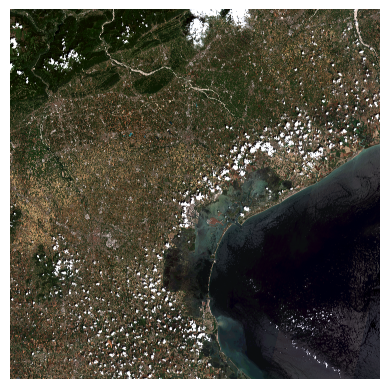

In [29]:
plt.imshow(img)
plt.axis('off')

In [30]:
df.to_csv("filtered_pixels.csv", index=False)

In [31]:
df.head()

,n_filaments,box_dims,n_max_pixels_fil,n_bands,s2_product,dec_time,x_centroid,y_centroid,lat_centroid,lon_centroid,n_pixels_fil,limits,pixel_x,pixel_y,pixel_spec
9595872,72,0,0,0,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.1259
9595873,72,0,0,1,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.1070
9595874,72,0,0,2,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0789
9595875,72,0,0,3,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0512
9595876,72,0,0,4,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0388


In [32]:
df[["n_filaments", "box_dims", "n_max_pixels_fil", "n_bands", "dec_time", "x_centroid", "y_centroid", "lat_centroid", "lon_centroid", "n_pixels_fil", "limits", "pixel_x", "pixel_y"]].head()

,n_filaments,box_dims,n_max_pixels_fil,n_bands,dec_time,x_centroid,y_centroid,lat_centroid,lon_centroid,n_pixels_fil,limits,pixel_x,pixel_y
9595872,72,0,0,0,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0
9595873,72,0,0,1,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0
9595874,72,0,0,2,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0
9595875,72,0,0,3,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0
9595876,72,0,0,4,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0


In [33]:
df.isna().sum(), len(df)

(n_filaments              0
 box_dims                 0
 n_max_pixels_fil         0
 n_bands                  0
 s2_product               0
 dec_time                 0
 x_centroid               0
 y_centroid               0
 lat_centroid             0
 lon_centroid             0
 n_pixels_fil             0
 limits                   0
 pixel_x             132444
 pixel_y             132444
 pixel_spec          132444
 dtype: int64,
 133276)

In [34]:
133276-132444

832

In [35]:
df[
    (df["pixel_x"] == 10333) &\
    (df["pixel_y"] == 7052)
]

,n_filaments,box_dims,n_max_pixels_fil,n_bands,s2_product,dec_time,x_centroid,y_centroid,lat_centroid,lon_centroid,n_pixels_fil,limits,pixel_x,pixel_y,pixel_spec
9595872,72,0,0,0,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.1259
9595873,72,0,0,1,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.1070
9595874,72,0,0,2,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0789
9595875,72,0,0,3,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0512
9595876,72,0,0,4,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0388
9595877,72,0,0,5,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0326
9595878,72,0,0,6,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0320
9595879,72,0,0,7,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0314
9595880,72,0,0,8,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0265
9595881,72,0,0,9,b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR...,2019.47515,10353.0,7080.0,45.056633,12.445637,16.0,7039.0,10333.0,7052.0,0.0063


In [36]:
df["n_filaments"].unique(), df["s2_product"].unique()

(array([72]),
 array([b'S2A_MSIL1C_20190623T101031_N0207_R022_T32TQR_20190623T122642.SAFE'],
       dtype=object))

In [ ]:
mask = np.zeros(img.shape[:2])

pixels = 0
pb = tqdm(df[
          (df["box_dims"] == 3) & (df["n_bands"] == 12)
          ].iterrows())
for index, row in pb:
    x, y = row["pixel_x"], row["pixel_y"]
    if not np.isnan(x) and not np.isnan(y):
    # if x is not None and y is not None:
        pixels += 1
        x, y = int(x), int(y)
        mask[x, y] = 255
        # mask[x, y] = fil_color_mapper[int(row["n_filaments"])%3]

2563it [00:00, 19082.07it/s]


In [ ]:
x_min = int(df["pixel_x"].min())
x_max = int(df["pixel_x"].max())
y_min = int(df["pixel_y"].min())
y_max = int(df["pixel_y"].max())

x_min, x_max, y_min, y_max

(10333, 10362, 7052, 7095)

In [39]:
(mask != 0).sum()

16

In [40]:
# fig, axes = plt.subplots(3, 2, figsize=(15, 10))
# axes = axes.flatten()# 
# for i, (p,n) in enumerate([(0, 0), (0, 255), (1, 255), (2, 255)]):
#     m = np.zeros((32, 32, 3))
#     m[:, :, ] = n
#     axes[i].imshow(m)

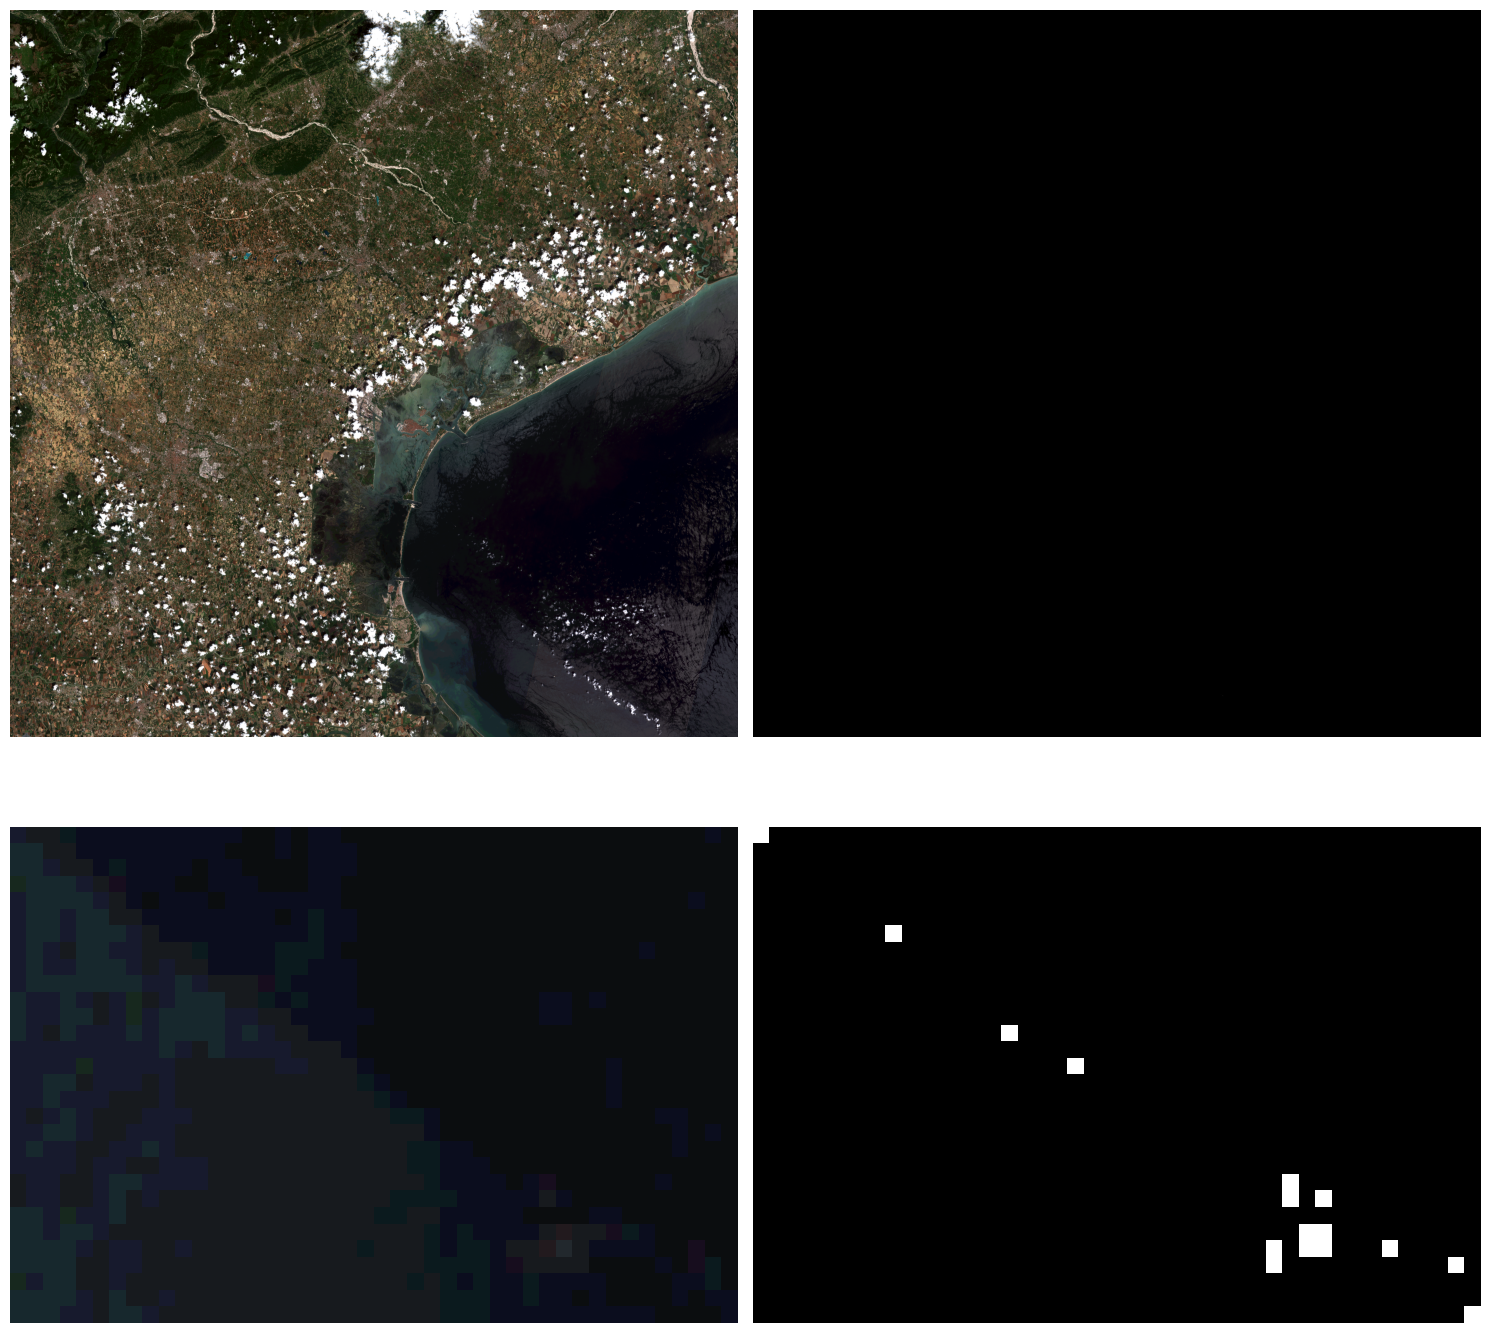

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

crop_img = img[x_min:x_max+1, y_min:y_max+1, :]
crop_mask = mask[x_min:x_max+1, y_min:y_max+1]

for i, plot in enumerate([img, mask, crop_img, crop_mask]):
    if isinstance(plot, int):
        marginalize()
    if i%2:
        axes[i].imshow(plot, cmap="gray")
    else:
        axes[i].imshow(plot)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(14, 2, figsize=(15, 15))
axes = axes.flatten()

for i, n in enumerate([2500, 1000, 500, 250, 100, 50, 0]):
    j = i*2
    overlap_img = np.ones_like(img)*255
    overlap_mask = np.ones_like(mask)*255

    x_start = max(x_min-n, 0)
    x_end = min(x_max+n+1, overlap_img.shape[0])

    y_start = max(y_min-n, 0)
    y_end = min(y_max+n+1, overlap_img.shape[1])

    
    overlap_img[x_start:x_end, y_min:y_max+1, :]  = np.array([50, 50, 50])
    overlap_mask[x_min:x_max+1, y_min:y_max+1] = 50

    overlap_img[x_min:x_max+1, y_min:y_max+1, :] = crop_img
    overlap_mask[x_min:x_max+1, y_min:y_max+1] = crop_mask
    
    axes[j].imshow(overlap_img)
    axes[j+1].imshow(overlap_mask, cmap="gray")


In [ ]:
raise Exception("f")